# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
# %matplotlib osx

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:
import sys
# sys.path.append("./")
sys.path.append("/Users/shua784/Dropbox/github/seacas/install/lib")

sys.path.append("../../watershed-workflow")
sys.path.append("../workflow_tpls")
sys.path.append("../workflow")

In [4]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
from matplotlib_scalebar.scalebar import ScaleBar
import shapely
import logging
import fiona
import rasterio
import pickle

import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)

In [5]:
def doArraysIntersect(array1, array2):
    return bool(set(array1) & set(array2))

In [6]:
watershed_name = "CoalCreek"
meshRes = "50m-sm150"
fname_surface_mesh = f"./meshes/{watershed_name}_surface_mesh.vtk"
fname_final_mesh = f"./meshes/{watershed_name}_final_mesh-{meshRes}.exo"

fig_mesh = "./figures/{}_mesh.png".format(watershed_name)
fig_mesh3D = "./figures/{}_mesh3D.png".format(watershed_name)
fig_soil_type = "./figures/{}_soil_type.png".format(watershed_name)
fig_geol_map = "./figures/{}_geol_map.png".format(watershed_name)
fig_land_cover = "./figures/{}_land_cover.png".format(watershed_name)
fig_hru = "./figures/{}_HRU.png".format(watershed_name)
fig_DTB = "./figures/{}_DTB.png".format(watershed_name)

fname_mesh_pickle = f'./results/{watershed_name}_mesh.p'
fname_soil_id = f'./results/{watershed_name}_soil_id-{meshRes}.txt'
fname_geol_id = f'./results/{watershed_name}_geol_id-{meshRes}.txt'

In [7]:
# specify the input shapefile and a hint as to what HUC it is in.
watershed_shapefile = '../data/hydrologic_units/EastTaylor/CoalCreek.shp'

fname_dem = "/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/EastTaylor_DEM/GreaterEastTayor_dem_10m.tif"
fname_soil = "/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/gNATSGO/gNATSGO_CO_raster/MapunitRaster_10m1.tif"
fname_DTB = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"
# fname_geology = "/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/EastTaylor_GLHYMPS/EastTaylor_GLHYMPS_v2.shp"
fname_geology = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/GLHYMPS_v2/GLHYMPS.shp"

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [8]:
# hint = '0410'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape


logging.info("")
logging.info("Meshing shape: {}".format(watershed_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)
logging.info("watershed CRS: {}".format(crs))

2021-02-04 09:27:54,305 - root - INFO: 
2021-02-04 09:27:54,306 - root - INFO: Meshing shape: ../data/hydrologic_units/EastTaylor/CoalCreek.shp
2021-02-04 09:27:54,306 - root - INFO: ==============================
2021-02-04 09:27:54,307 - root - INFO: 
2021-02-04 09:27:54,307 - root - INFO: Preprocessing Shapes
2021-02-04 09:27:54,308 - root - INFO: ------------------------------
2021-02-04 09:27:54,308 - root - INFO: loading file: "../data/hydrologic_units/EastTaylor/CoalCreek.shp"
2021-02-04 09:27:54,319 - root - INFO: src CRS: {'init': 'epsg:26913'}
2021-02-04 09:27:54,322 - root - INFO: watershed CRS: EPSG:26913


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [9]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
# use 10-m DEM instead
# sources['DEM'] = workflow.source_list.dem_sources['NED 1/3 arc-second']
workflow.source_list.log_sources(sources)

2021-02-04 09:27:56,266 - root - INFO: Using sources:
2021-02-04 09:27:56,266 - root - INFO: --------------
2021-02-04 09:27:56,267 - root - INFO: HUC: National Watershed Boundary Dataset (WBD)
2021-02-04 09:27:56,267 - root - INFO: hydrography: National Hydrography Dataset (NHD)
2021-02-04 09:27:56,268 - root - INFO: DEM: National Elevation Dataset (NED)
2021-02-04 09:27:56,268 - root - INFO: soil type: National Resources Conservation Service Soil Survey (NRCS Soils)
2021-02-04 09:27:56,269 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2021-02-04 09:27:56,269 - root - INFO: soil thickness: None
2021-02-04 09:27:56,270 - root - INFO: meteorology: DayMet 1km


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

## import river shapes

### download river hydrography from NHD

In [ ]:
# # find what HUC our shape is in
# huc = workflow.find_huc(sources['HUC'], watershed.exterior(), crs, hint = '1703', shrink_factor=0.1)
# logging.info("Found watershed in HUC: {}".format(huc))

In [10]:
huc = "140200010204" # provide the HUC8/HUC12 for NHD or HUC4 for NHDPlus that includes that watershed
simplify = 30 # length scale to target average edge

rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs,
                                     cvrt = True)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify,
                                         prune_reach_size=0,
                                         cut_intersections=True)

else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)



2021-02-04 09:28:49,626 - root - INFO: 
2021-02-04 09:28:49,626 - root - INFO: Preprocessing Hydrography
2021-02-04 09:28:49,627 - root - INFO: ------------------------------
2021-02-04 09:28:49,627 - root - INFO: Loading streams in HUC 140200010204
2021-02-04 09:28:49,628 - root - INFO:          and/or bounds (317251.2640131897, 4299711.408984916, 328473.7039815487, 4307062.45088187)
2021-02-04 09:28:49,629 - root - INFO: Using Hydrography file "/Users/shua784/OneDrive - PNNL/github/watershed-workflow/examples/data/hydrography/NHD_H_14020001_GDB/NHD_H_14020001.gdb"
2021-02-04 09:28:49,690 - root - INFO: transform crs EPSG:26913 to crs EPSG:4269
2021-02-04 09:28:49,850 - root - INFO:   found 176 reaches
2021-02-04 09:28:49,851 - root - INFO: convert to destination crs : EPSG:26913
2021-02-04 09:29:05,334 - root - INFO: out crs: EPSG:26913
2021-02-04 09:29:05,335 - root - INFO: convert to 176 shapely files
2021-02-04 09:29:05,344 - root - INFO: merge all shapely branched lines into a si

### plot watershed bnd and river networks

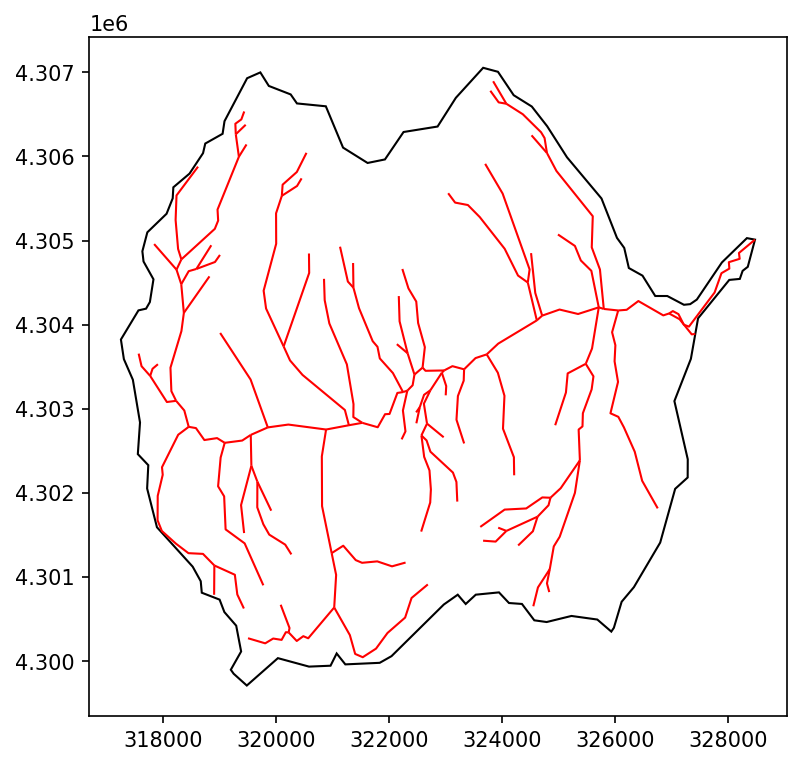

In [11]:
# plot what we have so far -- an image of the HUC and its stream network
fig,ax = plt.subplots(1,1, figsize=(6,6))
# ax = workflow.plot.get_ax(crs, fig)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

2021-02-04 09:29:15,739 - root - INFO: 
2021-02-04 09:29:15,739 - root - INFO: Meshing
2021-02-04 09:29:15,740 - root - INFO: ------------------------------
2021-02-04 09:29:15,740 - root - INFO: Triangulating...
2021-02-04 09:29:15,741 - root - INFO:    98 points and 98 facets
2021-02-04 09:29:15,742 - root - INFO:  checking graph consistency
2021-02-04 09:29:15,743 - root - INFO:  tolerance is set to 1
2021-02-04 09:29:15,744 - root - INFO:  building graph data structures
2021-02-04 09:29:15,745 - root - INFO:  triangle.build...
2021-02-04 09:29:15,746 - root - WARNING: Triangulate: '--enforce-delaunay' option requires a hacked `meshpy.triangle`.  Proceeding without this option because it is not recognized.
2021-02-04 09:29:32,037 - root - INFO:   ...built: 16732 mesh points and 33078 triangles
2021-02-04 09:29:32,037 - root - INFO: Plotting triangulation diagnostics
2021-02-04 09:29:34,848 - root - INFO:   min area = 348.2744140625 m^2
2021-02-04 09:29:34,851 - root - INFO:   max ar

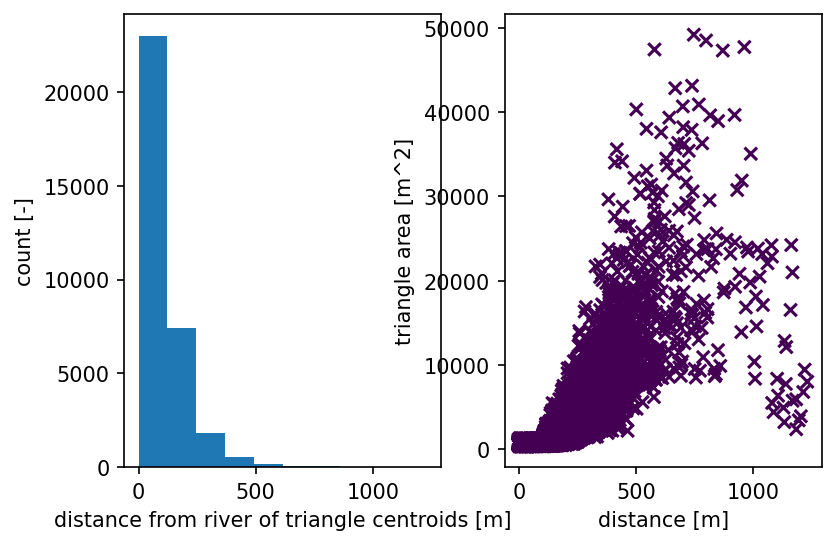

In [12]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500
# A0 = 10000; A1 = 50000 # [140, 310]m
# A0 = 5000; A1 = 50000 # [100, 310]m
# A0 = 1000; A1 = 50000 # [45, 310]m
A0 = 1250; A1 = 50000 # [50, 310]m

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, d = workflow.triangulate(watershed, rivers, 
                                              ignore_rivers = True,
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               enforce_delaunay=True,
                                               diagnostics=True)

## Download DEM

If mannually importing DEM, make sure the DEM map is slightly larger than the watershed boundary. Otherwise, artificial values may occur at the watershed boundary.

2021-02-04 09:29:47,691 - root - INFO: 
2021-02-04 09:29:47,692 - root - INFO: Preprocessing Raster
2021-02-04 09:29:47,692 - root - INFO: ------------------------------
2021-02-04 09:29:47,693 - root - INFO: collecting raster
2021-02-04 09:29:47,693 - root - INFO: loading file: "/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/EastTaylor_DEM/GreaterEastTayor_dem_10m.tif"
2021-02-04 09:29:47,775 - root - INFO: Got raster of shape: (928, 1562)
2021-02-04 09:29:47,776 - root - INFO: Got raster profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1562, 'height': 928, 'count': 1, 'crs': CRS.from_epsg(26913), 'transform': Affine(8.24584890771082, 0.0, 316421.8715668102,
       0.0, -10.099143426170167, 4308064.3539095), 'tiled': False, 'interleave': 'band'}
2021-02-04 09:29:47,776 - root - INFO: resamping raster using bilinear method...
2021-02-04 09:29:47,787 - root - INFO: dst_profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': No

<Figure size 900x600 with 0 Axes>

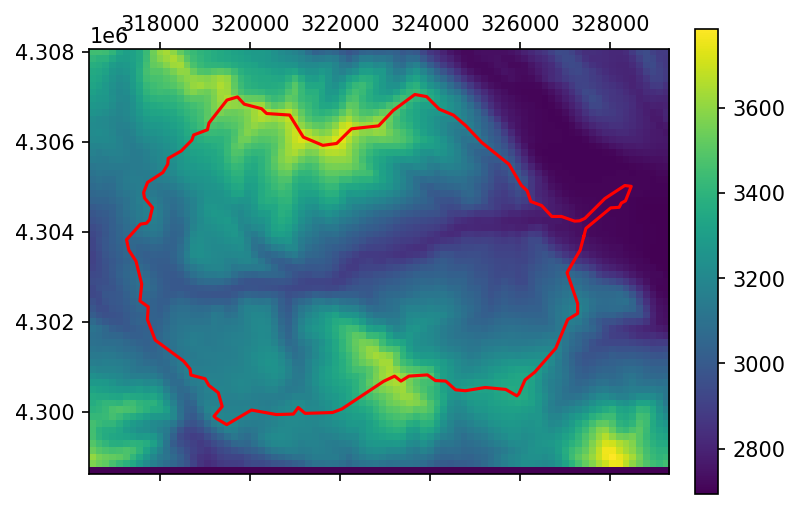

In [13]:
dem_profile, dem = workflow.get_raster_on_shape(fname_dem, watershed.exterior(), crs, offset = 100,
                                                 resampling_res=150, plot_dem= True, plot_nodata=False)

### Map mesh to DEM

In [14]:
# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)

2021-02-04 09:29:54,906 - root - INFO: 
2021-02-04 09:29:54,907 - root - INFO: Elevating Triangulation to DEM
2021-02-04 09:29:54,907 - root - INFO: ------------------------------


Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

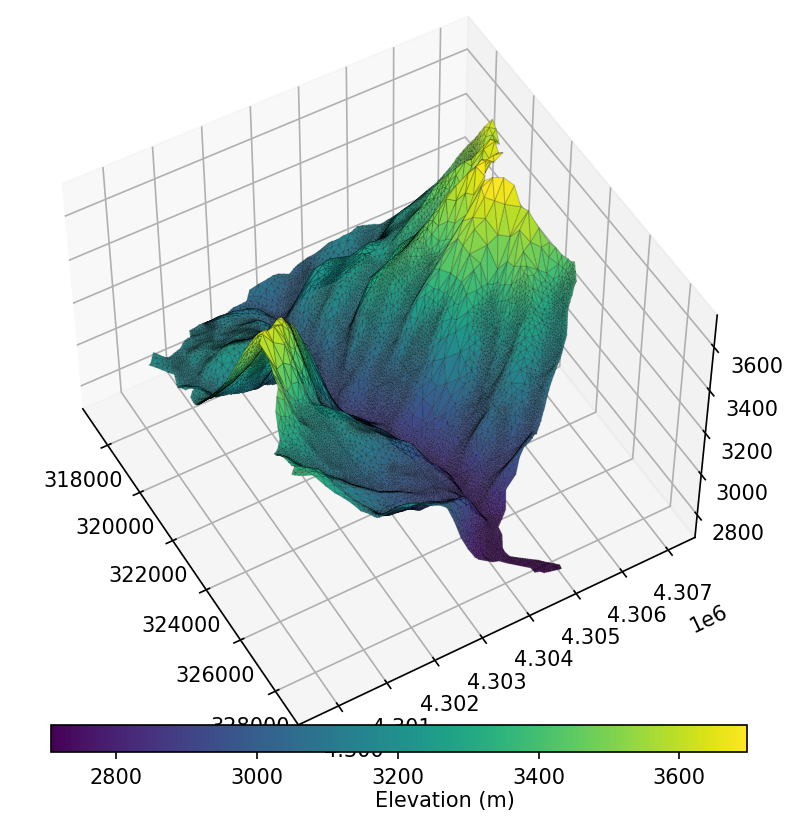

In [15]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

# t = cax.set_title('elevation [m]')
plt.text(0.5, -0.1, 'Elevation (m)', transform=ax.transAxes)

ax.view_init(50,-30)
# ax.set_xticklabels(list())
# ax.set_yticklabels(list())

# fig.savefig(fig_mesh3D, dpi = 300, transparent= True)

(316690.15495, 329034.55405000004)
(4299344.330884162, 4307420.049100754)


Text(0.5, 1.0, 'Elevation [m]')

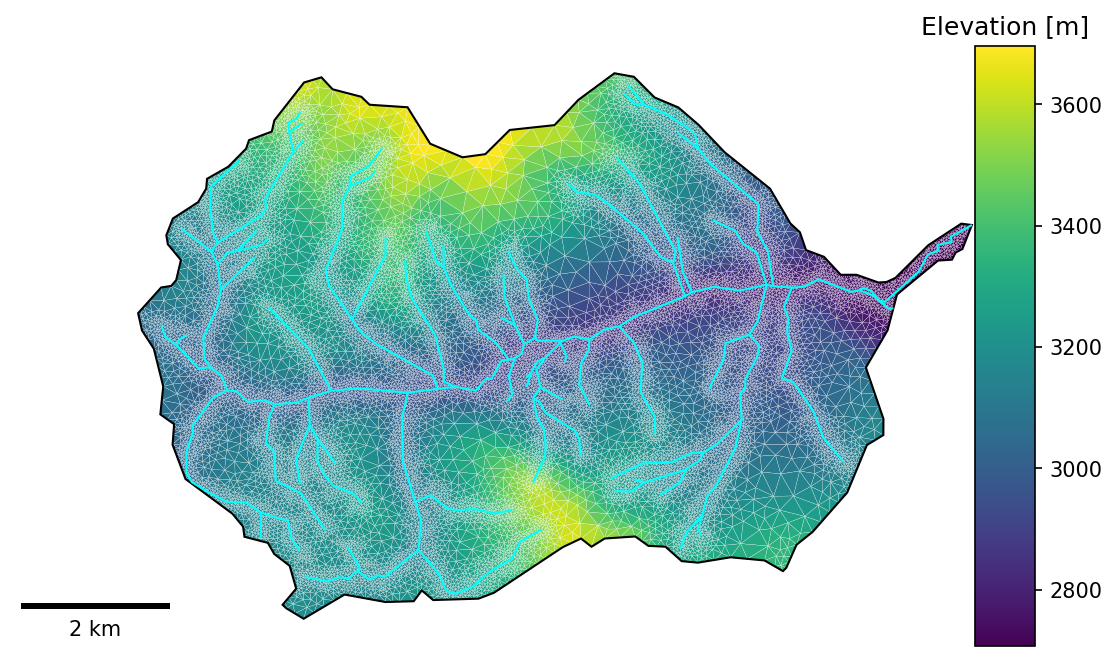

In [16]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(8,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
# ax2 = ax.inset_axes([0.58,0.45,0.3,0.3])
# cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbax = fig.add_axes([.85,0.1,0.05,0.8])

bxlim = (591000., 600000.)
bylim = (94000., 103000.)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')
# ax.set_xlim([770000, 800000])
# ax.set_ylim([4520000, 4550000])

# mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color='elevation', edgecolor='white', linewidth=0.5)
# workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1.5)
# ax2.set_xlim(bxlim)
# ax2.set_ylim(bylim)
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_aspect('equal', 'datalim')

# ax.indicate_inset_zoom(ax2, edgecolor='r')

# ax.margins(0.5)
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
scalebar1 = ScaleBar(1, location = "lower left")
ax.add_artist(scalebar1)
# scalebar2 = ScaleBar(1, location = "upper right")

# ax2.add_artist(scalebar2)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('Elevation [m]')

# fig.tight_layout()
# fig.savefig(fig_mesh, dpi = 300, transparent = True)

### construct 2d mesh 

In [17]:
# construct the 2D mesh
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

### Hydrologically condition the mesh

2021-02-04 09:30:40,025 - root - INFO: mesh is conditioned in place by removing pits using algorithm = 3 
2021-02-04 09:30:40,048 - root - INFO: max diff = 30.63065867894784 


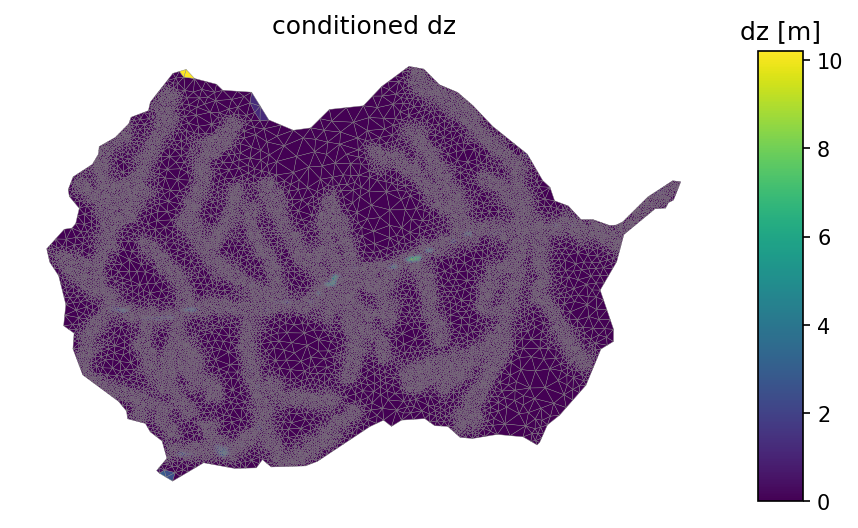

In [18]:
# hydrologically condition the mesh
workflow.condition.condition(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
logging.info(f"max diff = {np.abs(diff[:,2]).max()} ")
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
cbax = fig.add_axes([.95,0.25,0.05,0.5])

mp = workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
cbar.ax.set_title('dz [m]')
ax.axis('off')
ax.set_title('conditioned dz')
plt.show()

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [19]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs,
                                                     raster_crs=crs, 
#                                                      dst_crs = crs,
                                                     mask=False, 
                                                     nodata=-1)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2021-02-04 09:31:16,638 - root - INFO: 
2021-02-04 09:31:16,638 - root - INFO: Preprocessing Raster
2021-02-04 09:31:16,638 - root - INFO: ------------------------------
2021-02-04 09:31:16,639 - root - INFO: collecting raster
2021-02-04 09:31:16,662 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2021-02-04 09:31:16,785 - root - INFO: Got raster of shape: (1, 245, 374)
2021-02-04 09:31:16,785 - root - INFO: Got raster profil

In [20]:
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

# this is just hacking the label names to make them display a bit neater for a cleaner plot
nlcd_labels_fw = []
for label in nlcd_labels:
    label_fw = label
    if len(label) > 15:
        if ' ' in label:
            lsplit = label.split()
            if len(lsplit) == 2:
                label_fw = '\n'.join(lsplit)
            elif len(lsplit) == 4:
                label_fw = '\n'.join([' '.join(lsplit[0:2]),
                                      ' '.join(lsplit[2:])])
            elif len(lsplit) == 3:
                if len(lsplit[0]) > len(lsplit[-1]):
                    label_fw = '\n'.join([lsplit[0],
                                          ' '.join(lsplit[1:])])
                else:
                    label_fw = '\n'.join([' '.join(lsplit[:-1]),
                                          lsplit[-1]])
    nlcd_labels_fw.append(label_fw)

(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

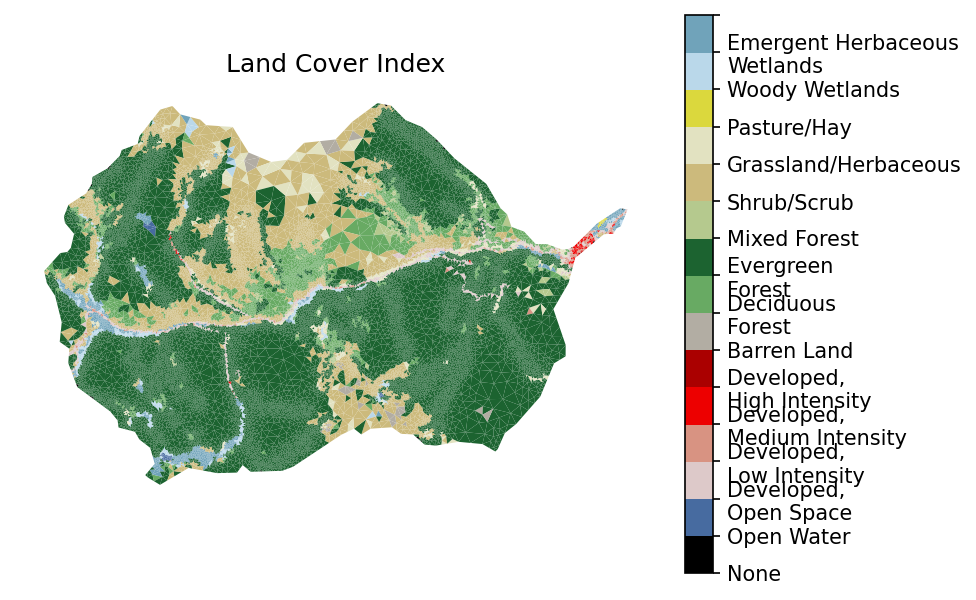

In [21]:
# plot the image
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
mp = pcm.ScalarMappable(norm=nlcd_norm, cmap=nlcd_cmap)
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
cb.set_ticks(nlcd_ticks)
cb.set_ticklabels(nlcd_labels_fw)
ax.set_title("Land Cover Index")
ax.axis('off')
# fig.tight_layout()
# fig.savefig(fig_land_cover, dpi = 300, transparent = True)

## Subsurface properties

### import soil map from gNATSGO raster

In [22]:
soil_profile, soil_raster = workflow.get_raster_on_shape(fname_soil, watershed.exterior(), crs)

2021-02-04 09:31:59,272 - root - INFO: 
2021-02-04 09:31:59,273 - root - INFO: Preprocessing Raster
2021-02-04 09:31:59,273 - root - INFO: ------------------------------
2021-02-04 09:31:59,274 - root - INFO: collecting raster
2021-02-04 09:31:59,274 - root - INFO: loading file: "/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/gNATSGO/gNATSGO_CO_raster/MapunitRaster_10m1.tif"
2021-02-04 09:31:59,399 - root - INFO: Got raster of shape: (732, 1119)
2021-02-04 09:31:59,400 - root - INFO: Got raster profile: {'driver': 'GTiff', 'dtype': 'int32', 'nodata': 2147483647.0, 'width': 1119, 'height': 732, 'count': 1, 'crs': CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_

In [23]:
# resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, soil_raster, soil_profile)

In [24]:
unique_soil_id = np.unique(soil_color)

In [25]:
logging.info(f'unique soil MUKEYs:\n {np.array(np.unique(soil_color, return_counts=True)).T}')

2021-02-04 09:32:12,695 - root - INFO: unique soil MUKEYs:
 [[498185    256]
 [498205    151]
 [498206   1047]
 [498208     21]
 [498229    664]
 [498231   4160]
 [509477   1082]
 [509479    354]
 [509481   1886]
 [509482   3865]
 [509513    427]
 [509514   1137]
 [509529    383]
 [509532   8270]
 [509544      1]
 [509547   1247]
 [509548   7753]
 [509559     40]
 [509561    125]
 [509577      5]
 [509733    106]
 [509794     98]]


In [26]:
np.savetxt(fname_soil_id, np.array(np.unique(soil_color, return_counts=True)).T, 
           delimiter=' ', fmt = '%.0d')

### plot soil map

(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

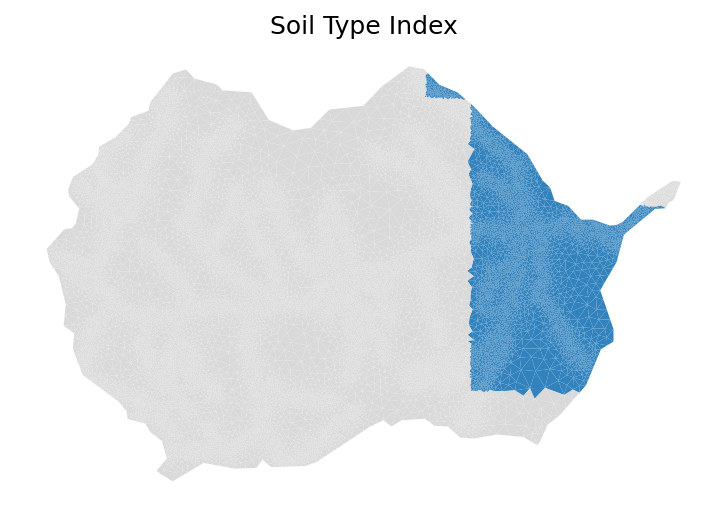

In [27]:
# plot the soil data
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=soil_color, cmap='tab20c')
ax.set_title('Soil Type Index')
ax.axis('off')
# ax.legend()

# fig.savefig(fig_soil_type, dpi = 300, transparent = True)

## map geology

1. Manually download global geology map (GLHYMPS v2.0) from [here](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/TTJNIU)
2. Extract the shapefile 
3. (optional) clip the global map to watershed shape. This will increase the processing speed.

In [28]:
target_bounds = watershed.exterior().bounds

_, geology = workflow.get_shapes(fname_geology, index_or_bounds=target_bounds, crs=crs)

2021-02-04 09:33:06,172 - root - INFO: 
2021-02-04 09:33:06,173 - root - INFO: Preprocessing Shapes
2021-02-04 09:33:06,174 - root - INFO: ------------------------------
2021-02-04 09:33:06,174 - root - INFO: loading file: "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/GLHYMPS_v2/GLHYMPS.shp"
2021-02-04 09:33:06,304 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
2021-02-04 09:33:26,883 - root - INFO: src CRS: {'proj': 'cea', 'lat_ts': 0, 'lon_0': 0, 'x_0': 0, 'y_0': 0, 'datum': 'WGS84', 'units': 'm', 'no_defs': True}


**map geology id to meshes**

In [29]:
# target_bounds = watershed.exterior().bounds
shape_union_bounds = shapely.ops.cascaded_union(geology).bounds

# -- log the bounds targetted and found
logging.info(f'target bounds: {target_bounds}')
logging.info(f'shape union bounds: {shape_union_bounds}')
if target_bounds[0] < shape_union_bounds[0] or target_bounds[1] < shape_union_bounds[1] or target_bounds[2] > shape_union_bounds[2] or target_bounds[3] > shape_union_bounds[3]:
    raise RuntimeError('target watershed falls outside the shape union bound!')

# -- determine the geology id for each polygon
geol_ids = np.array([shp.properties['OBJECTID_1'] for shp in geology], np.int32)

# convert shapefile to raster using geology ids
geol_color_raster, geol_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, target_dx=10, shapes=geology,
                                              shape_colors=geol_ids, shapes_crs = crs, nodata=-9999)

2021-02-04 09:33:32,447 - root - INFO: target bounds: (317251.2640131897, 4299711.408984916, 328473.4449929282, 4307052.970983125)
2021-02-04 09:33:32,447 - root - INFO: shape union bounds: (309452.03384970897, 4277422.824854819, 338890.05886956863, 4329709.205645651)
2021-02-04 09:33:32,448 - root - INFO: Coloring shapes onto raster:
2021-02-04 09:33:32,449 - root - INFO:   target_bounds = (317251.2640131897, 4299711.408984916, 328473.4449929282, 4307052.970983125)
2021-02-04 09:33:32,450 - root - INFO:   out_bounds = [317246.0, 4299708.0, 328486.0, 4307058.0]
2021-02-04 09:33:32,451 - root - INFO:   pixel_size = 10
2021-02-04 09:33:32,451 - root - INFO:   width = 1124, height = 735
2021-02-04 09:33:32,452 - root - INFO:   and 17 independent colors of dtype int32


In [30]:
# -- resample the raster to the triangles
geol_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geol_color_raster, geol_color_profile)

unique_geol_id = np.unique(geol_color)
logging.info(f'unique geology ids: {np.array(np.unique(geol_color, return_counts=True)).T}')

2021-02-04 09:33:33,015 - root - INFO: unique geology ids: [[715639   3647]
 [715707      3]
 [715766    334]
 [715779   3331]
 [715796     18]
 [726604   7076]
 [726608   4394]
 [726639  12884]
 [726642    590]
 [726664    163]
 [726667     19]
 [730801    619]]


In [31]:
np.savetxt(fname_geol_id, np.array(np.unique(geol_color, return_counts=True)).T, 
           delimiter=' ', fmt = '%.0d')

### plot geology map

(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

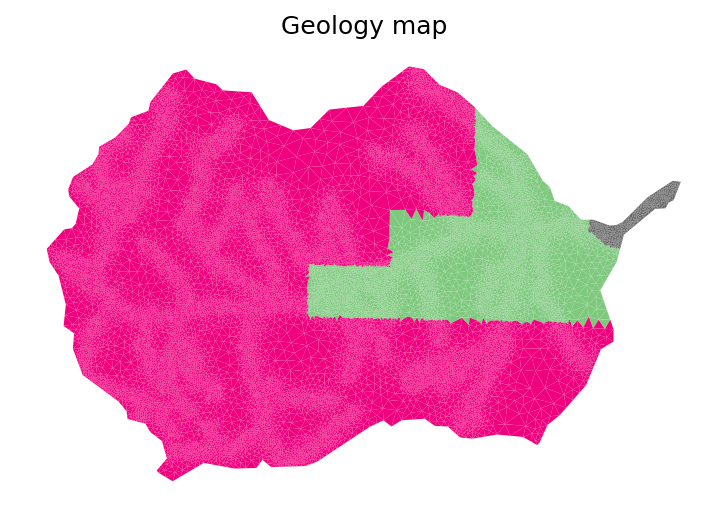

In [32]:
# plot the soil data
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geol_color, cmap='Accent')
ax.set_title('Geology map')
ax.axis('off')
# ax.legend()

# fig.savefig(fig_geol_map, dpi = 300, transparent = True)

## get bedrock depth

Download global depth to bedrock at 250 m resolution from [soilgrids](http://globalchange.bnu.edu.cn/research/dtb.jsp).

In [33]:
DTB_profile, DTB_raster = workflow.get_raster_on_shape(fname_DTB, watershed.exterior(), crs, nodata=-99999)

2021-02-04 09:34:13,466 - root - INFO: 
2021-02-04 09:34:13,467 - root - INFO: Preprocessing Raster
2021-02-04 09:34:13,468 - root - INFO: ------------------------------
2021-02-04 09:34:13,469 - root - INFO: collecting raster
2021-02-04 09:34:13,470 - root - INFO: loading file: "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"
2021-02-04 09:34:13,584 - root - INFO: Got raster of shape: (33, 63)
2021-02-04 09:34:13,585 - root - INFO: Got raster profile: {'driver': 'GTiff', 'dtype': 'int32', 'nodata': -99999.0, 'width': 63, 'height': 33, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.002083333, 0.0, -107.108344996,
       0.0, -0.002083333, 38.895007756), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
2021-02-04 09:34:13,585 - root - INFO: New raster of shape: (33, 63)
2021-02-04 09:34:13,586 - root - INFO: New raster crs: EPSG:4326
2021-02-

In [34]:
# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB_mesh = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile)

In [35]:
logging.info(f'minimum depth-to-bedrock: {np.nanmin(DTB_mesh)} m')
logging.info(f'maximum depth-to-bedrock: {np.nanmax(DTB_mesh)} m')

2021-02-04 09:34:14,271 - root - INFO: minimum depth-to-bedrock: 3.16 m
2021-02-04 09:34:14,272 - root - INFO: maximum depth-to-bedrock: 26.39 m


### plot depth to bedrock

In [36]:
DTB_3d = workflow.elevate(mesh_points2, crs, DTB_raster, DTB_profile)

2021-02-04 09:34:14,306 - root - INFO: 
2021-02-04 09:34:14,307 - root - INFO: Elevating Triangulation to DEM
2021-02-04 09:34:14,307 - root - INFO: ------------------------------


(316690.15495, 329034.55405000004)
(4299344.330884162, 4307420.049100754)


Text(0.5, 1.0, 'DTB [m]')

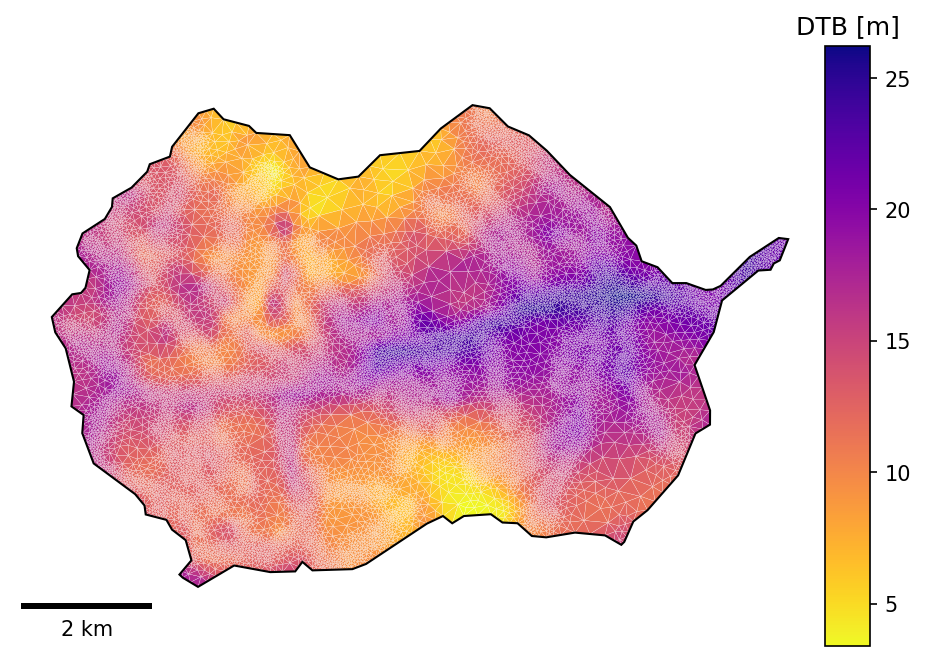

In [37]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

mp = workflow.plot.triangulation(DTB_3d, mesh_tris, crs, ax=ax, 
                                 color='elevation', cmap = 'plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

ax.set_aspect('equal', 'datalim')
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
scalebar1 = ScaleBar(1, location = "lower left")
ax.add_artist(scalebar1)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('DTB [m]')

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

In [38]:
total_tckness = np.ceil(DTB_mesh.max())
logging.info(f'total thickness: {total_tckness} m')

2021-02-04 09:35:33,170 - root - INFO: total thickness: 27.0 m


In [39]:
ele_per_layer = mesh_tris.shape[0]

In [40]:
if doArraysIntersect(unique_geol_id, unique_soil_id) or doArraysIntersect(unique_geol_id, [999]) or doArraysIntersect(unique_soil_id, [999]):
    raise RuntimeWarning('Common id is found in either soil/geol/bedrock!')

In [41]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z_top = []

z = 0.0
z_top.append(z)
# -- soil layer --
#  top 2 m
#  5 cm initial top cell
#  expanding dz, growing with depth
ncells = 6
dz = 0.05
layer_dz = 2 # total top thickness

tele = workflow.mesh.telescope_factor(ncells, dz, layer_dz)
logging.info("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color)
    z += dz
    dz = round(dz * tele, 2)
    z_top.append(z)    

# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
dz = 2.0

geo_ncells = int(np.ceil((total_tckness-z)/dz))
for i in range(geo_ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(geol_color)
    z += dz    
    z_top.append(z)

# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2021-02-04 09:35:33,275 - root - INFO: Converged?: ratio = 1.7857749000436356, layer z (target = 2) = -5.985434370359144e-12
2021-02-04 09:35:33,276 - root - INFO: Got telescoping factor: 1.7857749000436356
2021-02-04 09:35:33,277 - root - INFO: Cell summary:
2021-02-04 09:35:33,277 - root - INFO: ------------------------------------------------------------
2021-02-04 09:35:33,278 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2021-02-04 09:35:33,278 - root - INFO: ------------------------------------------------------------
2021-02-04 09:35:33,279 - root - INFO:  00 	| 00 	| 509794 	|   0.050000 	|   0.000000
2021-02-04 09:35:33,280 - root - INFO:  01 	| 01 	| 509794 	|   0.090000 	|   0.050000
2021-02-04 09:35:33,280 - root - INFO:  02 	| 02 	| 509794 	|   0.160000 	|   0.140000
2021-02-04 09:35:33,281 - root - INFO:  03 	| 03 	| 509794 	|   0.290000 	|   0.300000
2021-02-04 09:35:33,281 - root - INFO:  04 	| 04 	| 509794 	|   0.520000 	|   0.590000
2021-02-04 09:35:33,282 - root -

In [42]:
logging.info(f"No of cells: {len(layer_data)*ele_per_layer}")

2021-02-04 09:35:33,328 - root - INFO: No of cells: 628482


### add bedrock material

In [43]:
# get depth below top cell face
z_top = np.asarray(z_top)
z_center = z_top[:-1] + (z_top[1:]-z_top[:-1])/2

In [44]:
mat_ids = np.stack(layer_mat_ids)

for icol in np.arange(mat_ids.shape[1])[:]:
    idtb = DTB_mesh[icol]
    idx = z_center > idtb
    
    # assign 999 to bedrock
    mat_ids[idx, icol] = 999

In [45]:
layer_mat_ids = [mat_ids[row, :] for row in np.arange(mat_ids.shape[0])]

### extrusion

In [46]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

### add sidesets from land cover type

In [47]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [48]:
# save to disk
try:
    os.remove(fname_final_mesh)
except FileNotFoundError:
    pass
m3.write_exodus(fname_final_mesh)


You are using exodus.py v 1.19.1 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ./meshes/CoalCreek_final_mesh-50m-sm150.exo
Closing exodus file: ./meshes/CoalCreek_final_mesh-50m-sm150.exo
